# Import libraries

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import tensorflow
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from sklearn import preprocessing
import math

# Data Preprocessing

In [4]:
csv_file = "denser_data_collection.csv" #"denser_data_collection_marker.csv" #"data_collection.csv"
columns = ['Serial_no','Timestamp', 'x_actual', 'y_actual', 'direction', 'x_step', 'y_step']
data_df = pd.read_csv(csv_file, header=None, names = columns)

serial_numbers = data_df['Serial_no'].astype(str).apply(lambda x: int(x.split(',')[0]))

image_folder = "output_images_denser" #"output_images_denser_marker" #"cropped_noedges_new" #"output_images_new" #"images_resized_500"
# imagess_left = []
# imagess_right = []
X = []
Y = []

parsed_custom_info_left = []
parsed_custom_info_right = []


le = preprocessing.LabelEncoder()
data_df['direction'] = le.fit_transform(data_df['direction'])


count_direction_0 = data_df[data_df['direction'] == 0].shape[0]
count_direction_1 = data_df[data_df['direction'] == 1].shape[0]


print("Number of rows with direction 0:", count_direction_0)
print("Number of rows with direction 1:", count_direction_1)



serial_numbers = set(data_df['Serial_no'])
date_time = data_df['Timestamp']
x_coordinate = data_df['x_actual']
y_coordinate = data_df['y_actual']
direction = data_df['direction']
x_step = data_df['x_step']
y_step = data_df['y_step']


image_files = os.listdir(image_folder)


# contact = 0
# non_contact = 1

#Note: direction left = 0; right = 1

for row in data_df.itertuples(index=False, name='data_df'):
    serial_number = row.Serial_no
    date_time = row.Timestamp
    x_coordinate = row.x_actual
    y_coordinate = row.y_actual
    direction = row.direction
    x_step = row.x_step
    y_step = row.y_step


    ############################## contact and right direction data only
    if (110 <= y_step <= 162) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
    # if (-30 <= y_coordinate <= -21.5) and (-3.5 >= x_coordinate >= -8): 
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 1 and -12.5 <= x_coordinate <= 4.49:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    X.append(image)
                    Y.append(direction)
                    # parsed_custom_info_right.append([x_coordinate, y_coordinate])


    ############################# contact and left direction data only
    if (148 <= y_step <= 204) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
    # if (-30 <= y_coordinate <= -21.5) and (-7.5 >= x_coordinate >= -12.5):
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 0 and -18.81 <= x_coordinate <= -3.075:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    X.append(image)
                    Y.append(direction)

Number of rows with direction 0: 7853
Number of rows with direction 1: 7857


In [5]:
print(data_df.shape)

(15710, 7)


In [6]:
print(len(X))
print(len(Y))

1549
1549


In [7]:
from collections import Counter

In [8]:
Counter(Y)

Counter({1: 864, 0: 685})

In [9]:
print(data_df['direction'].isnull().sum())

0


In [10]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Sat Aug 19 22:23:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   46C    P8              32W / 300W |      6MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
data= list(zip(X, Y))

In [12]:
from keras.backend import set_session

<b>Note</b>: the next two blocks of code and the block of code towards the end where the session is closed was \
used to clear GPU memory. \
<b>Reference</b>: https://saturncloud.io/blog/how-to-clear-tensorflow-gpu-memory-after-model-execution/
\
<br>
<b>Important</b>: It is no longer necessary to use these three blocks of code. \
<b>A way round this problem</b>: Just refresh the kernel of the notebook once (a few times if necessary) \
to ensure the GPU memory gets cleared. 

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
config = tf.ConfigProto()
# config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)


In [15]:
print(len(data))


1549


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Shuffle and split the dataset
np.random.shuffle(data)


# Perform stratified split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [18]:
X_test1 = np.array(X_test)
X_train1 = np.array(X_train)

In [19]:
X_test1 = X_test1.astype('float32')
X_train1 = X_train1.astype('float32')

In [20]:
X_test1 /= 255

In [21]:
X_train1 /= 255

In [22]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [23]:
print("Shape X_train: ", np.shape(X_train1))
print("Shape Y_train: ", np.shape(Y_train))

print("Shape X_test: ", np.shape(X_test1))
print("Shape Y_test: ", np.shape(Y_test))

Shape X_train:  (1239, 1080, 1920, 3)
Shape Y_train:  (1239,)
Shape X_test:  (310, 1080, 1920, 3)
Shape Y_test:  (310,)


In [24]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [25]:
from keras.layers import MaxPooling2D

# ############################

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#    #######################

In [27]:
from keras.utils import to_categorical

# Convert integer labels to one-hot encoded categorical labels
Y_train_categorical = to_categorical(Y_train, num_classes=2)  # 2 classes

In [28]:
Y_test_categorical = to_categorical(Y_test, num_classes=2)  # 2 classes

# Model Training

In [29]:
num_classes = 2 # number of classes for classification

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Using categorical_crossentropy since classification


# Define the checkpoint path and directory
checkpoint_path = "checkpoints_classification_direction_leftright/weights_epoch_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Check if a checkpoint file exists, if yes, load the weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest is not None:
    print("Loading weights from the latest checkpoint:", latest)
    model.load_weights(latest)

# Define batch size and calculate the number of batches per epoch
batch_size = 8
# n_batches = len(X_train1) // batch_size

# Create a callback that saves the model's weights only at even epochs
def save_model_at_even_epochs(epoch, logs):
    if epoch % 1 == 0:
        model.save_weights(checkpoint_path.format(epoch=epoch))

cp_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model_at_even_epochs)

# Start training from the next epoch after the latest checkpoint
start_epoch = 0
if latest is not None:
    # Extract the epoch number from the checkpoint path
    start_epoch = int(latest.split("_")[-1].split(".")[0]) + 1

# Start training
history = model.fit(X_train1, Y_train_categorical, 
                    epochs=102,
                    initial_epoch=start_epoch,  # Start from the next epoch after the latest checkpoint
                    batch_size=batch_size, 
                    callbacks=[cp_callback])


Train on 1239 samples


2023-08-19 22:28:14.886831: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/conv2d/kernel/v/Assign' id:398 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/kernel/v, training/Adam/conv2d/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/102
1239/1239 [==============================] - 56s 45ms/sample - loss: 5.8412 - acc: 0.7571
Epoch 2/102
1239/1239 [==============================] - 49s 39ms/sample - loss: 0.2593 - acc: 0.9701
Epoch 3/102
1239/1239 [==============================] - 49s 40ms/sample - loss: 0.1672 - acc: 0.9871
Epoch 4/102
1239/1239 [==============================] - 48s 38ms/sample - loss: 0.0483 - acc: 0.9984
Epoch 5/102
1239/1239 [==============================] - 49s 40ms/sample - loss: 0.0443 - acc: 0.9976
Epoch 6/102
1239/1239 [==============================] - 49s 40ms/sample - loss: 0.0330 - acc: 0.9976
Epoch 7/102
1239/1239 [==============================] - 49s 39ms/sample - loss: 0.1580 - acc: 0.9895
Epoch 8/102
1239/1239 [==============================] - 48s 39ms/sample - loss: 0.0663 - acc: 0.9968
Epoch 9/102
1239/1239 [==============================] - 49s 40ms/sample - loss: 0.0201 - acc: 1.0000
Epoch 10/102
1239/1239 [==============================] - 50s 40ms/sample - loss: 

# Making preictions by loading the weights

In [27]:
# predictions = model.predict(X_new)
sample_index = 5  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-07-29 15:28:53.663538: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1/BiasAdd' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-07-29 15:28:54.855554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


Prediction: [[-13.773119   -24.760492     0.30121353   0.68982846]]


2023-07-29 15:28:55.283879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [28]:
print(Y_test[5])

[-14.24978661 -24.63892009   0.           1.        ]


# Making predictions by loading a saved model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model_path = "path/to/your/model.h5"
model = load_model(model_path)

# Assuming you have new data for prediction, you can use model.predict()
# For example, if you have new data in X_new, you can make predictions as follows:
# Load your new data for prediction, replace X_new with your data
X_new = ...

# Make predictions using the loaded model
predictions = model.predict(X_new)

# Print or use the predictions as required
print(predictions)

In [ ]:
model.load_weights("path_to_your_saved_weights.h5")  

In [24]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Wed Aug  9 20:46:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   44C    P8              31W / 300W |  33248MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Evaluation

In [30]:
import matplotlib.pyplot as plt

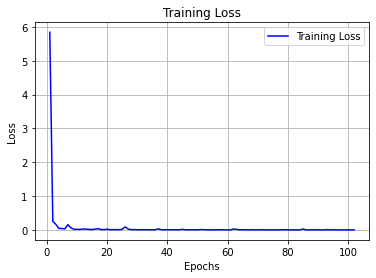

In [51]:
# Obtain the loss values from the training history
loss_values = history.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, len(loss_values) + 1)
# plt.ylim(0, max(loss_values) + 100)
plt.grid(True)
plt.legend()
plt.show()

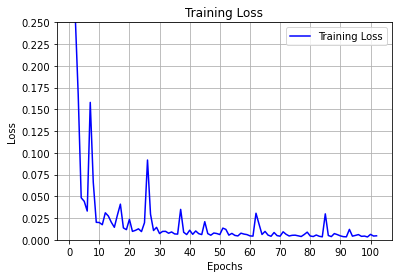

In [50]:
# Obtain the loss values from the training history
loss_values = history.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.ylim(0, 0.25)
plt.grid(True)
plt.yticks([i / 40 for i in range(0, 11)])
plt.xticks(range(0, len(loss_values) + 1, 10))


plt.legend()
plt.show()

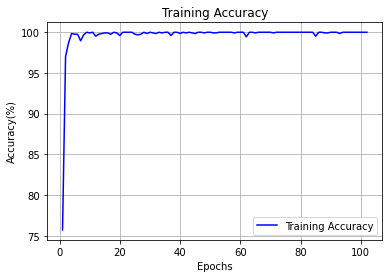

In [54]:
# Obtain the loss values from the training history
acc_values = history.history['acc']

# Convert decimal accuracy values to percentage
accuracy_percentage = [acc * 100 for acc in acc_values]

# Plot the loss graph
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, (accuracy_percentage), 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

# plt.ylim(0, 0.25)
plt.grid(True)
# plt.yticks([i / 40 for i in range(0, 11)])
# plt.xticks(range(0, len(loss_values) + 1, 10))


plt.legend()
plt.show()

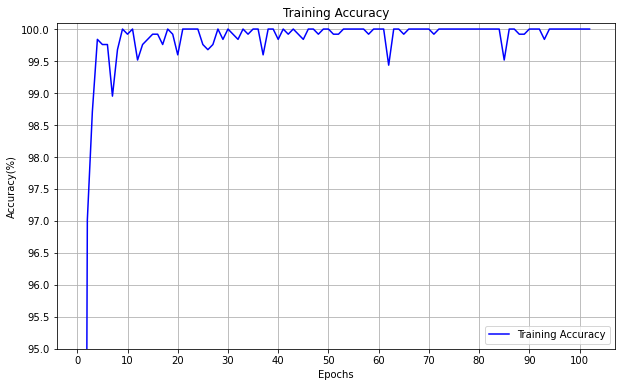

In [70]:
plt.figure(figsize=(10, 6)) 

# Obtain the loss values from the training history
acc_values = history.history['acc']

# Convert decimal accuracy values to percentage
accuracy_percentage = [acc * 100 for acc in acc_values]

# Plot the loss graph
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, (accuracy_percentage), 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.ylim(95, 100.1)
# plt.yticks(range(95, 101, 1))
plt.grid(True)
# plt.yticks([i / 40 for i in range(0, 11)])
# Calculate the number of ticks needed for 0.5% intervals
# num_ticks = int((max(accuracy_percentage) - min(accuracy_percentage)) / 0.5) + 1
num_ticks = int((max(accuracy_percentage) - 95) / 0.5) + 1


# Set y-axis ticks at intervals of 0.5% accuracy
plt.yticks([95 + 0.5 * i for i in range(num_ticks)])
plt.xticks(range(0, len(acc_values) + 1, 10))


plt.legend()
plt.show()

In [71]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test1, Y_test_categorical)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-20 01:44:51.402048: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/AddN_1' id:221 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Test Loss: 0.005145970296355024
Test Accuracy: 1.0


In [72]:
import matplotlib.cm as cm

In [73]:
import os

checkpoint_directory = "checkpoints_classification_direction_leftright/"

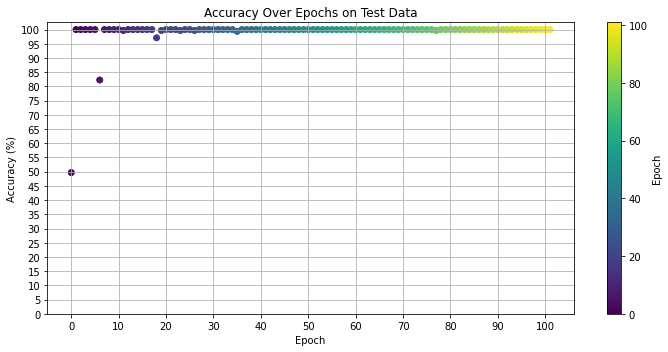

In [75]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs


# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(10, 5))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(0, 101, 5))

plt.tight_layout()
plt.show()

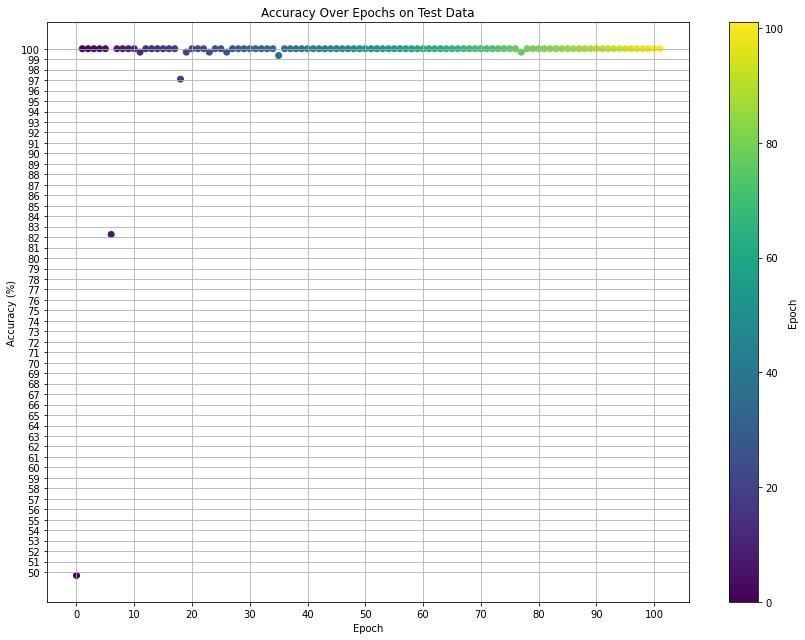

In [79]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_accuracies = {}  # Use a dictionary to store epoch accuracies

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch accuracy in the dictionary if it's higher
    if epoch_number not in epoch_accuracies or accuracy > epoch_accuracies[epoch_number]:
        epoch_accuracies[epoch_number] = accuracy * 100

epochs = sorted(epoch_accuracies.keys())  # Sort the epochs
accuracies = [epoch_accuracies[epoch] for epoch in epochs]  # Get accuracies corresponding to sorted epochs

# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(12, 9))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, accuracies, c=colormap(norm(epochs)), marker='o', label='Accuracy vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

plt.title('Accuracy Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(0, max(epochs) + 1, 10))
plt.yticks(range(50, 101, 1))

plt.tight_layout()
plt.show()

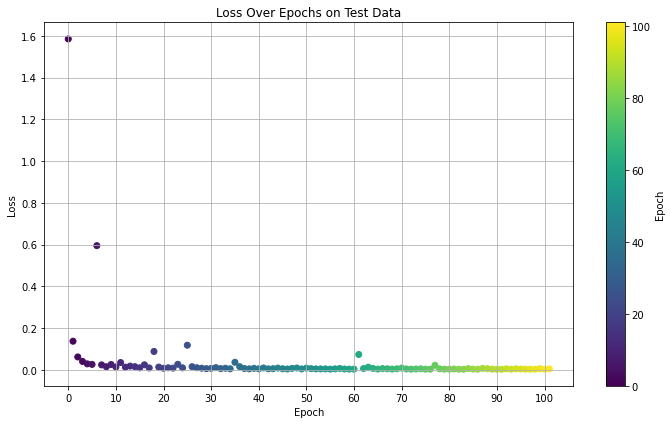

In [82]:
checkpoint_files = [filename for filename in os.listdir(checkpoint_directory) if filename.endswith(".ckpt.index")]
epoch_losses = {}  # Use a dictionary to store epoch losses

for checkpoint_file in checkpoint_files:
    filename_parts = checkpoint_file.split("_")
    epoch_part = filename_parts[2]
    epoch_number = int(epoch_part[:4])

    checkpoint_name = checkpoint_file.split(".")[0]
    checkpoint_path = os.path.join(checkpoint_directory, checkpoint_name)
    
    model.load_weights(checkpoint_path + ".ckpt")
    
    loss, accuracy = model.evaluate(X_test1, Y_test_categorical, batch_size=8, verbose=1)
    
    # Update the epoch loss in the dictionary if it's lower
    if epoch_number not in epoch_losses or loss < epoch_losses[epoch_number]:
        epoch_losses[epoch_number] = loss

epochs = sorted(epoch_losses.keys())  # Sort the epochs
losses = [epoch_losses[epoch] for epoch in epochs]  # Get losses corresponding to sorted epochs


# Create a colormap
colormap = cm.viridis

# Normalize epoch values to the colormap range
norm = plt.Normalize(min(epochs), max(epochs))

# Create a scalar mappable to map epochs to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Set an empty array to ensure correct color mapping

plt.figure(figsize=(10, 6))
# Use the ScalarMappable to assign colors to data points
plt.scatter(epochs, losses, c=colormap(norm(epochs)), marker='o', label='Loss vs Epoch')

# Add a colorbar to show the epoch values
cbar = plt.colorbar(sm)
cbar.set_label('Epoch')

# plt.plot(losses, marker='o')
plt.title('Loss Over Epochs on Test Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 0.5)
# plt.xlim(0, 200)

plt.grid(True)

# Set the x-axis ticks to display every 10 epochs
plt.xticks(range(0, 105 + 1, 10))

# Draw grid lines on the y-axis at every 0.025 loss interval
# plt.yticks([i / 40 for i in range(36)])


plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Testing

In [84]:
sample_index = 6  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

Prediction: [[9.9999523e-01 4.8208358e-06]]


In [5]:
sess.close()
tf.reset_default_graph()


In [1]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Fri Jul 28 10:38:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX 6000...  On   | 00000000:41:00.0 Off |                  Off |
| 55%   77C    P2   270W / 300W |  40369MiB / 49140MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX 6000...  On   | 00000000:61:00.0 Off |                  Off |
| 30%   